In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

C:\Users\brazen\AppData\Local\Temp\ipykernel_11348\82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# загрузка пакетов: инструменты --------------------------------------------
# работа с массивами
import numpy as np
# фреймы данных
import pandas as pd
# распределение Стьюдента для проверки значимости
from scipy.stats import t
# подсчёт частот внутри массива
from collections import Counter
# графики
import matplotlib as mpl
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets
# загрузка пакетов: модели -------------------------------------------------
# стандартизация показателей
from sklearn.preprocessing import StandardScaler
# метод главных компонент
from sklearn.decomposition import PCA
# метод частных наименьших квадратов
from sklearn.cross_decomposition import PLSRegression
# логистическая регрессия (ММП)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
# перекрёстная проверка по k блокам
from sklearn.model_selection import KFold, cross_val_score
# расчёт Acc и сводка по точности классификации
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder


In [3]:
# константы
# ядро для генератора случайных чисел
my_seed = 17
# создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
# примеры стилей и шаблонов графиков:
# http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-v0_8')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
sns.color_palette("Set2")

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [4]:
# функция, которая строит график сжатия коэффициентов в ридж и лассо
# из репозитория к книге С.Рашки Python и машинное обучение,
# слегка переработанная
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names,
  C_min_pow=-4, C_max_pow=3.) :
  fig = plt.figure()
  ax = plt.subplot(111)

  # палитра
  colors = sns.color_palette("Spectral", len(col_names)-1)

  weights, params = [], []
  for c in np.arange(C_min_pow, C_max_pow+1):
    lr = LogisticRegression(penalty=penalty_name, \
    C=10.**c, solver='liblinear',
    multi_class='ovr', random_state=my_seed)
    lr.fit(X, y)
    weights.append(lr.coef_[class_number])
    params.append(10**c)

  weights = np.array(weights)
  for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
    label=col_names[column],
    color=color)
    
  # отсечки по оптимальным C
  plt.axvline(x=C_opt[class_number], color='magenta',
  linestyle='--', linewidth=1)

  plt.axhline(0, color='black', linestyle='--', linewidth=1)
  plt.xlim([10**(C_min_pow), 10**C_max_pow])
  plt.ylabel('weight coefficient')
  plt.xlabel('C')
  plt.xscale('log')
  plt.legend(loc='upper left')
  ax.legend(loc='upper center',
  bbox_to_anchor=(1.38, 1.03),
  ncol=1, fancybox=True)
  plt.show()

# **Загружаем данные**

Загружаем данные варианта 17

In [5]:
url = 'https://raw.githubusercontent.com/ania607/ML/main/data/default_of_credit_card_clients.csv'
DF_all = pd.read_csv(url)
DF_all.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Исключим лишние столбцы согласно варианту и отложим 15% наблюдений

In [6]:
cols_to_remove = ["PAY_4", "PAY_5", "PAY_6", "BILL_AMT4", "BILL_AMT5",
"BILL_AMT6", "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4",
"PAY_AMT5", "PAY_AMT6"]
DF_all = DF_all.loc[:, ~DF_all.columns.isin(cols_to_remove)]
DF = DF_all.sample(frac=0.85, random_state=my_seed)
DF_predict = DF_all.drop(DF.index)

In [7]:
DF_all.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'Y'],
      dtype='object')

In [8]:
len(DF.columns)

12

In [9]:
DF.iloc[:, :6].head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0
15854,130000,2,2,1,27,0
7388,150000,1,3,2,41,0
1799,130000,1,3,2,28,0
735,70000,2,3,1,50,-2
22485,20000,2,2,1,43,0


In [10]:
DF.iloc[:, 6:12]

,PAY_2,PAY_3,BILL_AMT1,BILL_AMT2,BILL_AMT3,Y
15854,0,0,76885,79106,81231,0
7388,0,0,64425,57073,32516,0
1799,0,0,132258,133781,133834,0
735,-2,-1,27345,-1041,17571,0
22485,0,0,11511,12521,13851,0
...,...,...,...,...,...,...
3657,0,0,104014,108229,109374,0
16382,2,2,536,210,-116,1
23982,0,0,72850,74937,75900,0
25212,-1,2,1434,4925,390,0


In [11]:
DF['PAY_3'].value_counts()

PAY_3
 0    13378
-1     5047
-2     3476
 2     3265
 3      203
 4       63
 7       22
 5       20
 6       20
 8        3
 1        3
Name: count, dtype: int64

In [12]:
DF.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
Y            int64
dtype: object

In [13]:
DF.isna().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
Y            0
dtype: int64

# **Предварительный анализ данных**

## **Описательные статистики**

In [14]:
DF.Y.unique()

array([0, 1], dtype=int64)

Считаем доли классов

In [15]:
np.around(DF.Y.value_counts() / len(DF.index), 3)

Y
0    0.779
1    0.221
Name: count, dtype: float64

Всего два класса, причем доля клиентов без дефолта в три раза выше, чем с ним

Рассчитаем описательные статистики для объясняющих переменных

In [16]:
DF.iloc[:, :6].describe().style.format('{:.2f}')

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0
count,25500.00,25500.00,25500.00,25500.00,25500.00,25500.00
mean,168409.79,1.60,1.85,1.55,35.50,-0.02
std,130337.09,0.49,0.79,0.52,9.23,1.13
min,10000.00,1.00,0.00,0.00,21.00,-2.00
25%,50000.00,1.00,1.00,1.00,28.00,-1.00
50%,140000.00,2.00,2.00,2.00,34.00,0.00
75%,240000.00,2.00,2.00,2.00,41.00,0.00
max,1000000.00,2.00,6.00,3.00,79.00,8.00


In [17]:
DF.iloc[:, 6:11].describe().style.format('{:.2f}')

,PAY_2,PAY_3,BILL_AMT1,BILL_AMT2,BILL_AMT3
count,25500.00,25500.00,25500.00,25500.00,25500.00
mean,-0.14,-0.16,51278.39,49240.65,47093.67
std,1.20,1.20,74022.43,71578.92,69773.06
min,-2.00,-2.00,-165580.00,-67526.00,-157264.00
25%,-1.00,-1.00,3577.75,2990.00,2691.00
50%,0.00,0.00,22137.00,20897.00,20035.00
75%,0.00,0.00,66855.50,63620.25,59946.00
max,8.00,8.00,964511.00,983931.00,1664089.00


**Вывод по описательным статистикам**: масштабы переменных различаются

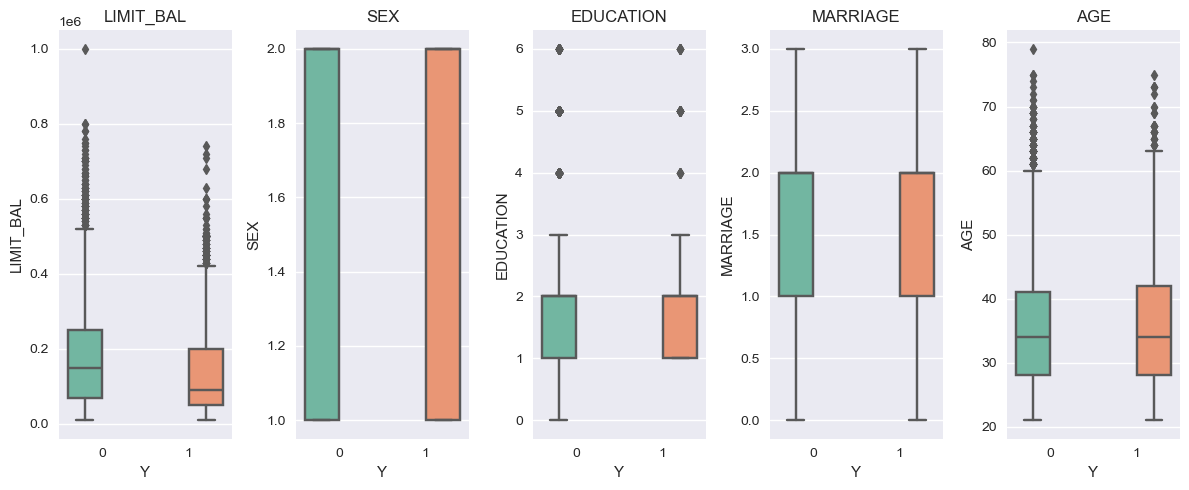

In [18]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])
axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[:5].values)
for col_name in cols_loop :
  i = cols_loop.index(col_name)
  g = sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i], hue='Y')
  axs[i].set_ylabel(col_name)
  axs[i].set_title(col_name)
  axs[i].get_legend().remove()
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

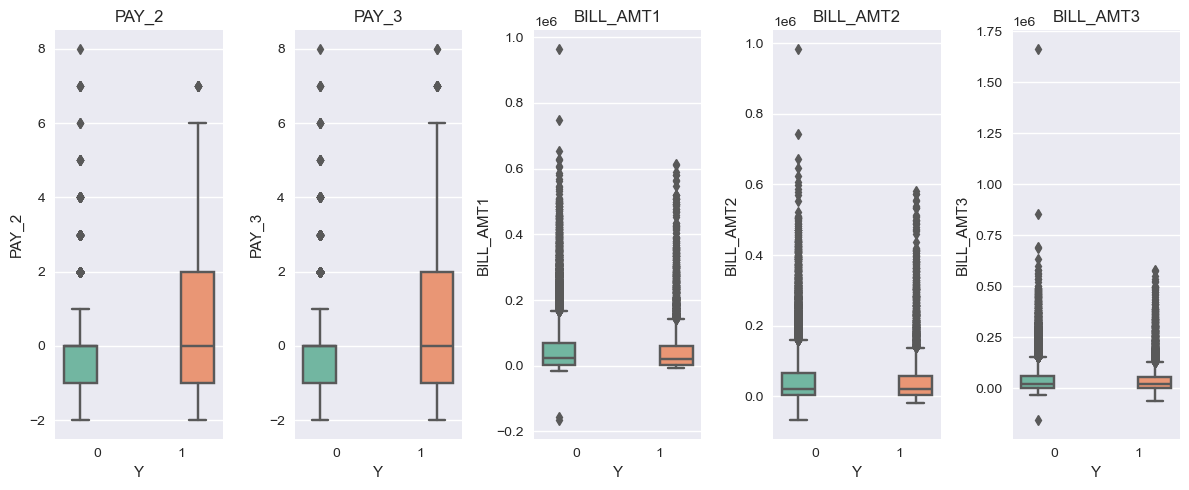

In [19]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])
axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[6:11].values)
for col_name in cols_loop :
  i = cols_loop.index(col_name)
  g = sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i], hue='Y')
  axs[i].set_ylabel(col_name)
  axs[i].set_title(col_name)
  axs[i].get_legend().remove()
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

## **Корреляционный анализ**


<Axes: >

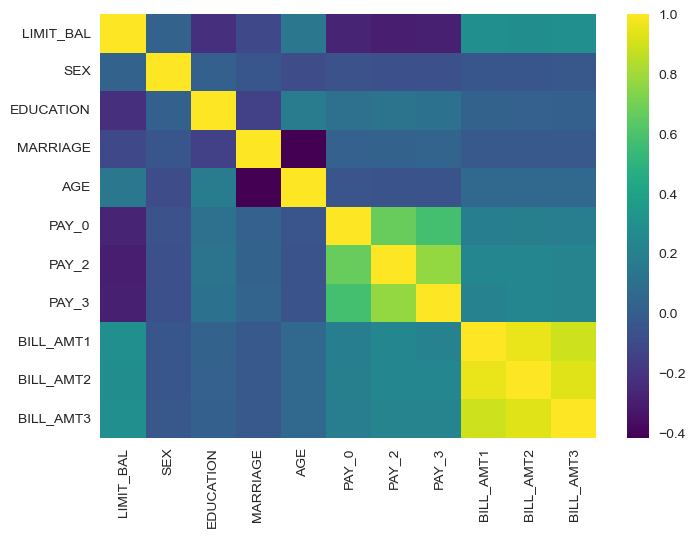

In [20]:
X = DF.drop('Y', axis=1)
corr_mat = X.corr()
col_names = X.columns
sns.heatmap(X.corr(), cmap='viridis')

In [21]:
df = corr_mat
df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
df = df.stack().reset_index()
df.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']
t_stat = np.sqrt((len(DF.index) - 2) / (1 - df.Корреляция.values ** 2))
df['P_значение'] = 2*(1 - t.cdf(abs(t_stat), len(DF.index) - 2))
# получили все корреляционные коэффициенты без 1 и без повторов
# выводим все значимые и с сильной степенью корреляции больше 0.4
df.loc[( df['P_значение'] < 0.05 ) & ( df['Корреляция'].apply(abs) > 0.4 )] \
    .sort_values('Корреляция', key=abs, ascending=False)

,Показатель_1,Показатель_2,Корреляция,P_значение
52,BILL_AMT1,BILL_AMT2,0.950832,0.0
54,BILL_AMT2,BILL_AMT3,0.928650,0.0
53,BILL_AMT1,BILL_AMT3,0.891680,0.0
45,PAY_2,PAY_3,0.768484,0.0
40,PAY_0,PAY_2,0.673593,0.0
41,PAY_0,PAY_3,0.575632,0.0
27,MARRIAGE,AGE,-0.415197,0.0


# Снижение размерности

Стандартизация

In [22]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X.values)

for i, col in enumerate(X_train_std.T):
    print(f'{i}. mean: {np.round(np.mean(col))}',
          f' std: {np.round(np.std(col))}', sep='')

0. mean: -0.0 std: 1.0
1. mean: 0.0 std: 1.0
2. mean: 0.0 std: 1.0
3. mean: 0.0 std: 1.0
4. mean: 0.0 std: 1.0
5. mean: -0.0 std: 1.0
6. mean: 0.0 std: 1.0
7. mean: 0.0 std: 1.0
8. mean: -0.0 std: 1.0
9. mean: -0.0 std: 1.0
10. mean: 0.0 std: 1.0


# Регрессия на главные компоненты

Пересчет X в главные компоненты

In [23]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
frac_var_expl = pca.explained_variance_ratio_
print('Доли объясненной дисперсии')
pd.DataFrame(np.round(frac_var_expl, 3)).transpose()

Доли объясненной дисперсии


,0,1,2,3,4,5,6,7,8,9,10
0,0.301,0.214,0.137,0.093,0.083,0.052,0.048,0.04,0.02,0.01,0.004


PCs are orthogonal

In [24]:
X_train_pca = pd.DataFrame(X_train_pca)
corr_mat = X_train_pca.corr()
np.round(corr_mat, 2)

,0,1,2,3,4,5,6,7,8,9,10
0,1.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0
1,0.0,1.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0
2,-0.0,-0.0,1.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0
3,-0.0,0.0,-0.0,1.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
4,-0.0,-0.0,0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0
5,-0.0,0.0,0.0,0.0,-0.0,1.0,0.0,-0.0,-0.0,0.0,-0.0
6,-0.0,0.0,-0.0,-0.0,-0.0,0.0,1.0,0.0,0.0,-0.0,0.0
7,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,1.0,0.0,0.0,-0.0
8,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,1.0,0.0,0.0
9,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,1.0,0.0


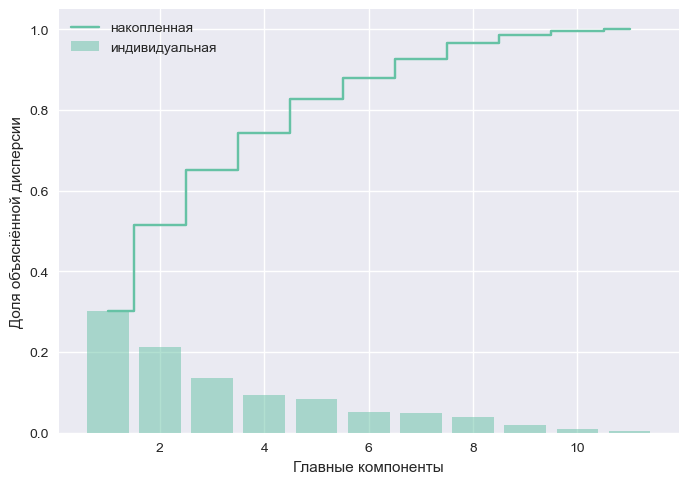

In [25]:
# график объяснённой дисперсии
plt.bar(range(1, 12), pca.explained_variance_ratio_, alpha=0.5,
align='center', label='индивидуальная')
plt.step(range(1, 12), np.cumsum(pca.explained_variance_ratio_),
where='mid', label='накопленная')
plt.ylabel('Доля объяснённой дисперсии')
plt.xlabel('Главные компоненты')
plt.legend()
plt.show()

По графику, видно, что первые 5
компонент объясняют около 80% исходной дисперсии.

Чтобы увидеть, как классы выглядят в координатах ГК на графике, придётся сократить
пространство для двух компонент, которые объясняют 51% разброса объясняющих
переменных.

<Axes: xlabel='PC1', ylabel='PC2'>

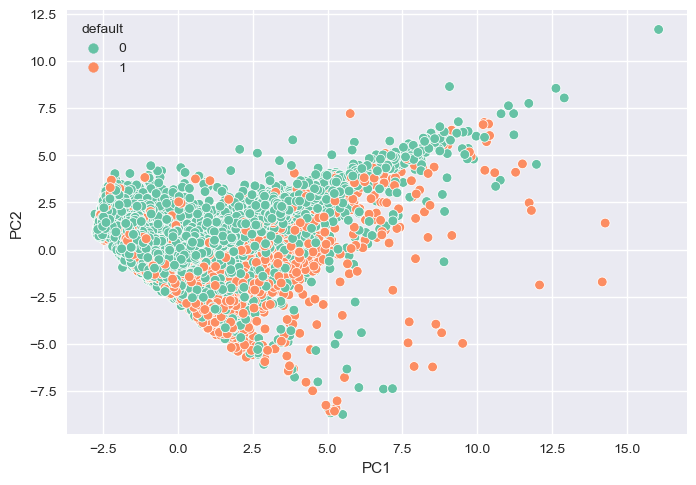

In [26]:
pc_labels = {i:f'PC{i+1}' for i in range(X_train_pca.shape[0])}
X_train_pca.rename(columns=pc_labels, inplace=True)
X_train_pca.index = DF.Y.index
X_train_pca['default'] = DF.Y
sns.scatterplot(X_train_pca, x='PC1', y='PC2', hue='default')

In [27]:
logit = LogisticRegression()
kf_10 = KFold(n_splits=10, random_state=my_seed, shuffle=True)

score = list()
Y_train = DF.Y.values
acc = cross_val_score(logit, X_train_pca[['PC1', 'PC2']], Y_train,
                      cv=kf_10, scoring='accuracy').mean()
score.append(np.around(acc, 3))
score_models = list()
score_models.append('logit_PC2')
print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам',
    '\nAcc = ', np.around(score[0], 3), sep='')

Модель logit_PC2, перекрёстная проверка по 10 блокам
Acc = 0.798


In [28]:
logit = LogisticRegression()
kf_10 = KFold(n_splits=10, random_state=my_seed, shuffle=True)

Y_train = DF.Y.values
acc = cross_val_score(logit, X_train_pca.loc[:, 'PC1':'PC5'], Y_train,
                      cv=kf_10, scoring='accuracy').mean()
score.append(np.around(acc, 3))
score_models.append('logit_PC5')
print('Модель ', score_models[1], ', перекрёстная проверка по 10 блокам',
    '\nAcc = ', np.around(score[1], 3), sep='')

Модель logit_PC5, перекрёстная проверка по 10 блокам
Acc = 0.804


# Регуляризация

Простроим ридж-регрессию

In [29]:
logit_ridge = LogisticRegression(penalty='l2', solver='liblinear')
logit_ridge.fit(X_train_std, Y_train)
print('Constants:')
display(pd.DataFrame(np.around(logit_ridge.intercept_, 3)))
print('Coefficients:')
display(pd.DataFrame(np.around(logit_ridge.coef_, 3)))

Constants:


,0
0,-1.437


Coefficients:


,0,1,2,3,4,5,6,7,8,9,10
0,-0.157,-0.041,-0.081,-0.092,0.064,0.682,0.109,0.141,-0.151,0.028,-0.049


Подбираем гиперпараметр регуляризации $ \lambda $ с помощью перекрёстной проверки. В функции LogisticRegression() аргумент $ C $ – это инверсия гиперпараметра $ \lambda $.

In [30]:
ridge_cv = LogisticRegressionCV(cv=10, random_state=my_seed+2,
                                penalty='l2', solver='liblinear')
ridge_cv.fit(X_train_std, Y_train)
ridge_cv.C_

array([0.35938137])

In [31]:
score.append(np.around(ridge_cv.score(X_train_std, Y_train), 3))
score_models.append('logit_ridge')
print('Модель ', score_models[1], ', перекрёстная проверка по 10 блокам',
    '\nAcc = ', score[1], sep='')

Модель logit_PC5, перекрёстная проверка по 10 блокам
Acc = 0.804


Изобразим изменение коэффициентов ридж-регрессии на графике и сделаем отсечку на уровне оптимального параметра

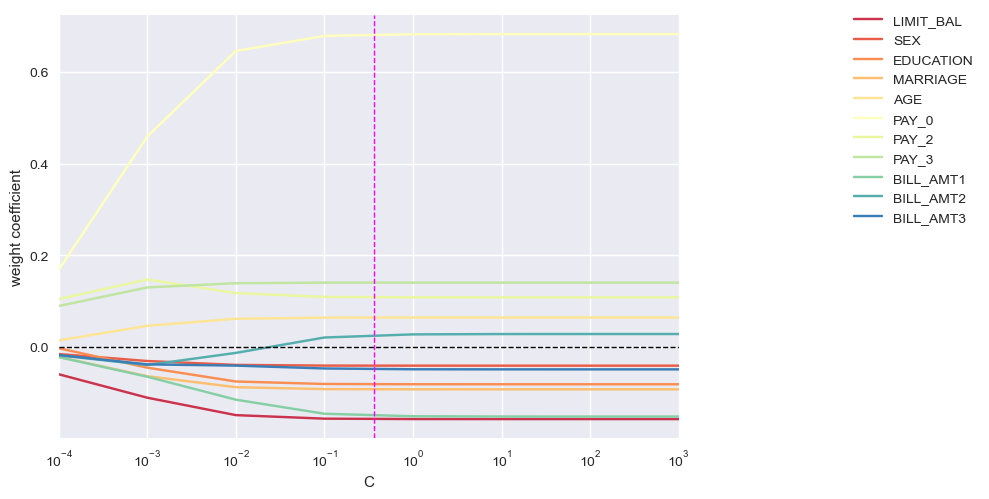

In [32]:
# class 0
plot_coeffs_traces(X_train_std, Y_train, 0, 'l2', ridge_cv.C_, DF.columns)

# Прогноз на отложенные наблюдения по лучшей модели

In [33]:
pd.DataFrame({'Model':score_models, 'Acc':score})

,Model,Acc
0,logit_PC2,0.798
1,logit_PC5,0.804
2,logit_ridge,0.810


Обе модели показывают высокую точность по показателю Acc, при этом самой точной
оказывается ридж-регрессия. Сделаем прогноз на отложенные наблюдения

In [34]:
X_pred_std = sc.fit_transform(DF_predict.drop('Y', axis=1).values)
Y_pred = DF_predict.Y
Y_hat = logit_ridge.predict(X_pred_std)
print(classification_report(Y_pred, Y_hat))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      3503
           1       0.71      0.24      0.36       997

    accuracy                           0.81      4500
   macro avg       0.76      0.61      0.62      4500
weighted avg       0.79      0.81      0.77      4500



Низкая чувствительность (recall)  для истинного класса говорит о наличии большого количества ложноотрицательных результатов предсказания. Иначе говоря, модель часто игнорирует default-еров, что может быть критичным при принятии решении о выдаче кредита.

Возможная причина - неравенство долей классов. Попробуем устранить это с помощью корректировки весов на доли классов.

In [35]:
# построим новую модель со сбалансированнми классами весов
ridge_cv_balanced = LogisticRegressionCV(cv=10, random_state=my_seed+2,
                                penalty='l2', solver='liblinear',
                                class_weight='balanced')
ridge_cv_balanced.fit(X_train_std, Y_train)
ridge_cv_balanced.C_

array([0.35938137])

In [36]:
score.append(np.around(ridge_cv_balanced.score(X_train_std, Y_train), 3))
score_models.append('logit_ridge_balanced')
print('Модель ', score_models[3], ', перекрёстная проверка по 10 блокам',
    '\nAcc = ', score[3], sep='')

Модель logit_ridge_balanced, перекрёстная проверка по 10 блокам
Acc = 0.701


Accuracy пострадала не сильно по сравнению с предыдущими моделями. Посмотрим на метрики качества прогноза

In [37]:
Y_hat = ridge_cv_balanced.predict(X_pred_std)
print(classification_report(Y_pred, Y_hat))

              precision    recall  f1-score   support

           0       0.87      0.72      0.79      3503
           1       0.39      0.63      0.48       997

    accuracy                           0.70      4500
   macro avg       0.63      0.67      0.63      4500
weighted avg       0.76      0.70      0.72      4500



Точность положительного прогноза упала, в то время как полнота увеличилась.

Как мы уже заметили, в задаче выдачи кредита ложноположительные результаты могут быть более критичны, чем  ложноотрицательные, т.е. лучше выдавать кредиты меньшим людям, но с большей уверенностью, что они вернут кредит. С этой точки зрения модель с балансировкой классов оказывается лучше.